<!DOCTYPE html>
<html>
<head>
<style>
* {
  box-sizing: border-box;
}

.column {
  float: left;
  width: 50%;
  padding: 1px;
}

/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}


</style>
</head>
<body>

<h2>CNN and example</h2>

<div class="row">
  <div class="column">
    <img src="cnn.png" alt="General CNN" width=500 height=100>
  </div>
  <div class="column">
    <img src="celebs.png" alt="CNN celebs, from google images"  width=500 height=100>
  </div>
</div>

</body>
</html>



<h3 style="color: red;">Student: Rexiati Dilimulati </h3>
<h4 style="color: red;">rishat.dilmurat@gmail.com</h4>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
from IPython.display import Image, HTML, display
import time

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
torch.manual_seed(0);

<header class="centered-header">
    <h1 style="color:Tomato;">My Mission</h1>
    <h2>Classify Fashion-MNIST Dataset Using CNN</h2>
</header>
<table><tr><td><img src='fasion01.jpg'></td><td><img src='fasion01.jpg'></td></tr></table>

<h1 style="color:Tomato;">CNN</h1>

In [7]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, num_conv_layers, num_classes=10):
        # To initilize the parent nn.Module
        super(CNN, self).__init__()
        
        # To avoid one by one define multiple conv layrs, nn.ModuleList works like list, 
        # which links to nn.Module so that we are able to use module properties. 
        self.conv_layers = nn.ModuleList()
        
        # Define the first layer 
        self.conv_layers.append(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1))
        
        # Add subsequent convolutional layers
        for _ in range(1, num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1))
        
        self.maxpool=nn.MaxPool2d(kernel_size=2)
     
        # Define the fully connected layers
        # CLASSIFICATION
        self.fc1 = nn.Linear(16 * 3 * 3, 120)  
        self.fc2 = nn.Linear(120, 60) 
        self.fc3 = nn.Linear(60, num_classes)
    
    # Prediction
    def forward(self, x):
        for conv in self.conv_layers:
            x = self.maxpool(F.relu(conv(x)))
        
        # Flatten the output
        x = x.view(-1, 16 * 3 * 3)
        
        
        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

<h1 style="color:Tomato;">CNN_batch</h1>

In [9]:
class CNN_batch(nn.Module):
    
    # Contructor
    def __init__(self, num_conv_layers, num_classes=10):
        super(CNN_batch, self).__init__()

        self.conv_layers = nn.ModuleList()
        #self.conv_bn = nn.ModuleList()
        # Define the first layer 
        self.conv_layers.append(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1))
        


        for _ in range(1, num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1))
            #self.conv_bn.append(nn.BatchNorm2d(16))

        self.conv_bn = nn.BatchNorm2d(16)
        self.maxpool=nn.MaxPool2d(kernel_size=2)  # maxpool (2*2)

        # Define the fully connected layers
        # CLASSIFICATION
        self.fc1 = nn.Linear(16 * 3 * 3, 120) 
        self.bn_fc1 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 60) 
        self.bn_fc2 = nn.BatchNorm1d(60)
        self.fc3 = nn.Linear(60, num_classes)
        #self.bn_fc3 = nn.BatchNorm1d(10)

    
    # Prediction
    def forward(self, x):
        for conv in self.conv_layers:
            x = self.maxpool(F.relu(self.conv_bn(conv(x))))
        
        # Flatten the output
        x = x.view(-1, 16 * 3 * 3)
        
        # Forward pass through fully connected layers
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = F.relu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

<h1 style="color:Tomato;">Train the model</h1>

In [11]:
def train_model(model, criterion, train_loader, validation_loader, optimizer, n_epochs=4):
    
    N_test = len(validation_loader.dataset)
    accuracy_list=[]
    loss_list=[]
    for epoch in range(n_epochs):
        cost = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)  # with GPU

            start_gpu.record()  # start to record

            # forward + backward + optimize
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            cost = cost+loss.data
            
            end_gpu.record()   # enf of GPU running time
             
        loss_list.append(cost)

        
        correct=0
        #perform a prediction on the validation  data  
        for x_test, y_test in validation_loader:
            x_test, y_test = x_test.to(device), y_test.to(device)  # with GPU
            model.eval()
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
     
    return accuracy_list, loss_list

In [12]:
# Create the training dataset
train_dataset = dsets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

In [13]:
# Create the validation dataset
validation_dataset = dsets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [14]:
len(validation_dataset)

10000

In [15]:
# Create the data loader for training and validation
batch_size = 500
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=True)

<h1 style="color:Tomato;">With CNN</h1>

In [17]:
# Create the criterion function
criterion = nn.CrossEntropyLoss()

# Create the parameters
num_conv_layers = 3

#model = CNN(num_conv_layers)
model = CNN(num_conv_layers).to(device)

# define optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# start to play 
start_gpu = torch.cuda.Event(enable_timing=True)
end_gpu = torch.cuda.Event(enable_timing=True)

start_cpu = time.time()
training_results_CNN = train_model(model, criterion, train_loader, validation_loader, optimizer, n_epochs=200)
end_cpu = time.time()

print(f'Total CPU time: {(end_cpu - start_cpu)/60:.3f} mins')
print(f'Total GPU time: {start_gpu.elapsed_time(end_gpu)/(60*1000):.3f} mins')
#%timeit t_cpu @ t_cpu
#%timeit t_gpu @ t_gpu

Total CPU time: 27.263 mins
Total GPU time: 0.000 mins


<h1 style="color:Tomato;"> With CNN_batch</h1>

In [52]:
# Create the criterion function
criterion = nn.CrossEntropyLoss()

# Create the parameters
num_conv_layers = 3

#model = CNN_batch(num_conv_layers)
model = CNN_batch(num_conv_layers).to(device)

# define optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# start to play 
start_gpu = torch.cuda.Event(enable_timing=True)
end_gpu = torch.cuda.Event(enable_timing=True)

start_cpu = time.time()
training_results_CNN_batch = train_model(model, criterion, train_loader, validation_loader, optimizer, n_epochs=400)
end_cpu = time.time()

print(f'Total CPU time: {(end_cpu - start_cpu)/60:.3f} mins')
print(f'Total GPU time: {start_gpu.elapsed_time(end_gpu)/(60*1000):.3f} mins')
#%timeit t_cpu @ t_cpu
#%timeit t_gpu @ t_gpu

KeyboardInterrupt: 

<h1 style="color:Tomato;">Show results</h1>

In [135]:
def show_data(data_sample):
    plt.imshow(data_sample[0][0].numpy(), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

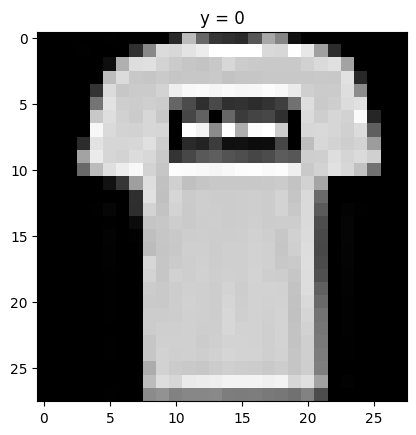

In [139]:
show_data(train_loader.dataset[1])

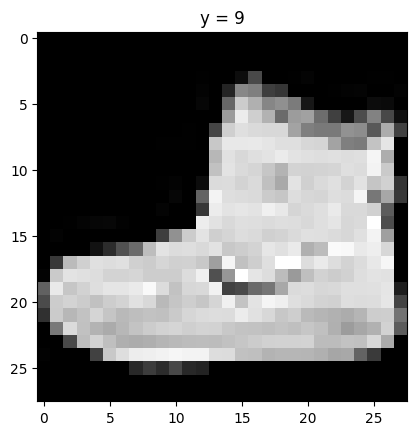

In [141]:
show_data(train_loader.dataset[0])

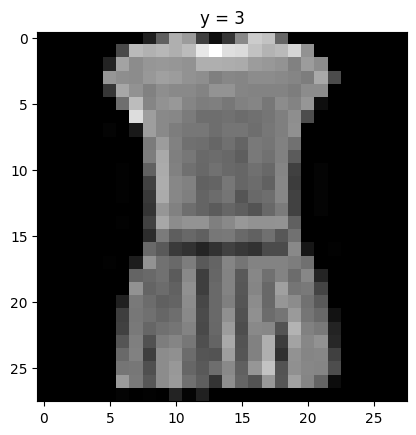

In [143]:
show_data(train_loader.dataset[3])

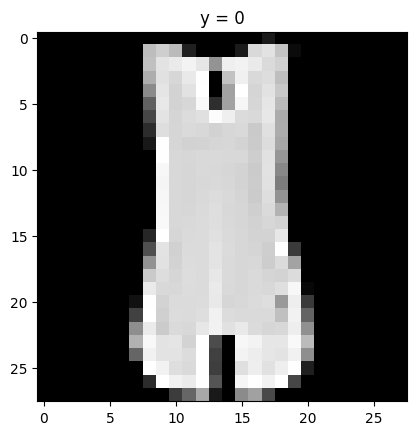

In [145]:
show_data(train_loader.dataset[4])

In [ ]:
show_data(train_loader)

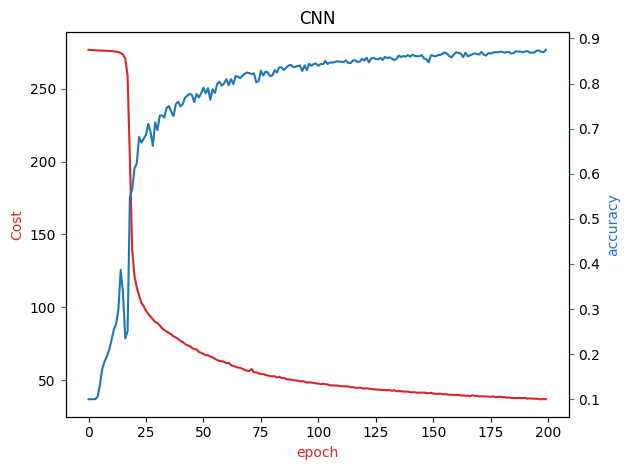

In [83]:
# Plot the loss and accuracy for CNN

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(torch.tensor(training_results_CNN[1]).numpy(), color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
plt.title("CNN")
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(training_results_CNN[0], color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()

In [73]:
torch.tensor(training_results_CNN[1]).numpy()

array([276.62195 , 276.49298 , 276.39447 , 276.31573 , 276.24823 ,
       276.18665 , 276.12427 , 276.05328 , 275.9642  , 275.8627  ,
       275.74078 , 275.58136 , 275.355   , 275.0125  , 274.4433  ,
       273.35757 , 270.67368 , 258.874   , 201.51213 , 139.67545 ,
       121.58805 , 113.58549 , 108.053894, 103.09376 , 100.80969 ,
        97.651   ,  95.45595 ,  93.66283 ,  91.72836 ,  89.99028 ,
        89.373665,  87.53375 ,  85.67331 ,  84.410355,  83.349884,
        82.4052  ,  81.43883 ,  80.09516 ,  79.307335,  78.309525,
        77.03871 ,  76.230644,  74.912895,  74.005066,  73.39372 ,
        72.28046 ,  71.27348 ,  71.2587  ,  69.33623 ,  68.889755,
        68.11632 ,  67.12878 ,  67.146614,  66.31002 ,  65.67521 ,
        64.71154 ,  63.8775  ,  63.240677,  63.107407,  62.59471 ,
        61.684566,  61.982697,  60.437958,  59.758293,  59.32339 ,
        58.63666 ,  58.590595,  57.782967,  57.031433,  56.54822 ,
        56.285587,  57.70078 ,  55.33264 ,  55.464447,  54.700

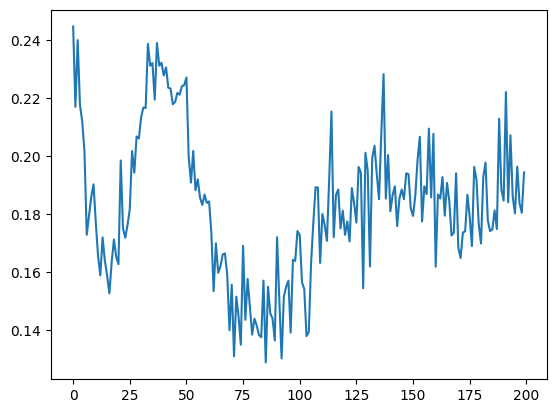

In [47]:
plt.plot(torch.tensor((training_results_CNN_batch[0])), "-")

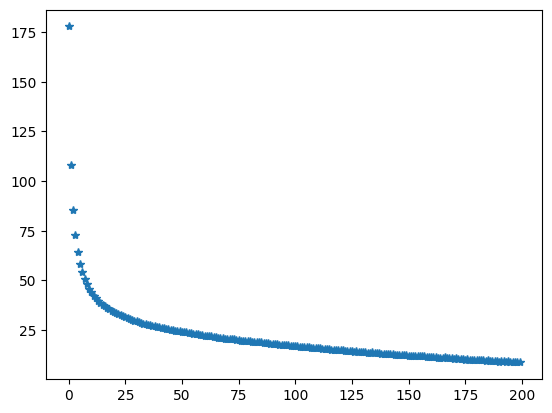

In [27]:
plt.plot(torch.tensor((training_results_CNN_batch[1])), "*")

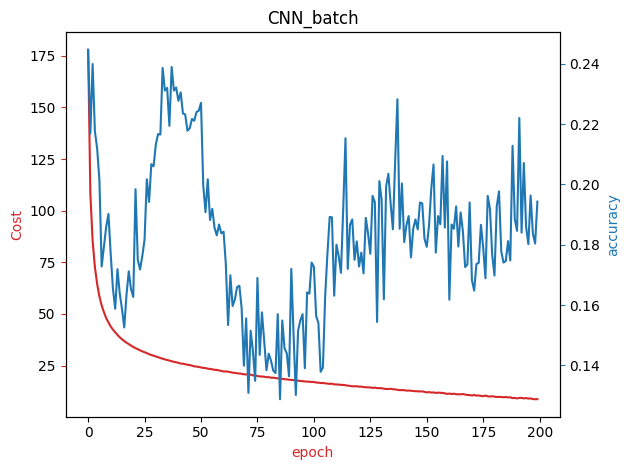

In [79]:
# Plot the loss and accuracy for CNN_batch

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(torch.tensor(training_results_CNN_batch[1]).numpy(), color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
plt.title("CNN_batch")
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(training_results_CNN_batch[0], color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()